In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score, rand_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import datasets
import pandas as pd

In [2]:
n_samples = 300
random_state=50
np.random.seed(random_state)

Kmeans my friend azzam has written it

In [3]:
class KMeans():
    def __init__(self, k, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations
        self.centroids = None

    def initialize_centroids(self, dataset):
        indices = np.random.choice(dataset.shape[0], self.k, replace=False)
        self.centroids = dataset[indices]

    @staticmethod
    def closest_centroid(dataset, centroids):
        distances = np.sqrt(((dataset - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    @staticmethod
    def recompute_centroids(dataset, closest, k):
        return np.array([dataset[closest == ki].mean(axis=0) for ki in range(k)])

    def fit(self, dataset):
        self.initialize_centroids(dataset)
        for _ in range(self.max_iterations):
            closest = self.closest_centroid(dataset, self.centroids)
            new_centroids = self.recompute_centroids(dataset, closest, self.k)
            if np.all(self.centroids == new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, dataset):
        return self.closest_centroid(dataset, self.centroids)


from here till the end I wrote it

GMM distribution

$p(x) = \sum_{i=1}^K \pi_i \mathcal{N}(x | \mu_i, \Sigma_i)$

$r_k(x) = p(z=k|x)= \frac{p(x|k)p(k)}{\sum_{k=1}^K p(k)p(x|k)} = \frac{p(x|k)\pi_k}{\sum_{K} \pi_k p(x|k)}$


In [4]:
class GMM():
    def __init__(self, k,  mu=None, sigma=None, pi=None,patience=5, max_iter=300):
        self.k=k
        self.mu=mu
        self.sigma=sigma
        self.pi=pi
        self.patience=patience
        self.max_iter=max_iter


    def _E_step(self, X):
        '''Evaluate the responsibilities'''

        for k in range(self.k):
            self.r[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.sigma[k])
            
        self.r /= self.r.sum(axis=1, keepdims=True)


    def _M_step(self, X):

        N_ks=self.r.sum(axis=0)
        new_mu=(self.r.T@X)/N_ks[:,None]
        
        new_sigma=np.zeros((self.k, X.shape[1], X.shape[1]), dtype=np.float32)
        for k in range(self.k):
            for n in range(X.shape[0]):
                x_u=X[n]-new_mu[k]
                x_u=x_u[:,None]
                new_sigma[k]+= self.r[n][k]*(x_u@x_u.T)
                
            new_sigma[k]/=N_ks[k]


        new_pi=N_ks/X.shape[0]
        return new_mu, new_sigma, new_pi

    def _evaluate(self):
        return np.sum(np.log(self.r.sum(axis=1)))


    def fit(self, X):
        
        if self.mu is None:
            self.mu=np.random.rand(self.k, X.shape[1])
        
        if self.sigma is None:
            self.sigma=np.array([np.eye(X.shape[1]) for _ in range(self.k)])
            # self.sigma=np.ones((self.k, X.shape[1], X.shape[1]))
        
        if self.pi is None:
            self.pi=np.full(self.k, 1/self.k)
        
        self.r=np.empty((X.shape[0], self.k), dtype=np.float32)

        last_score=float('-inf')
        no_improvment=0
        for i in range(self.max_iter):
            self._E_step(X)
            mu, sigma, pi=self._M_step(X)
            score=self._evaluate()

            if score<= last_score :
                no_improvment+=1
            
            if no_improvment> self.patience:
                # print("finsh", i)
                break

            self.mu=mu
            self.sigma=sigma
            self.pi=pi
            last_score=score
        



    def score(self, X):
        r=np.empty((X.shape[0], self.k), dtype=np.float32)
        for k in range(self.k):
            r[:, k] = self.pi[k] * multivariate_normal.pdf(X, mean=self.mu[k], cov=self.sigma[k])
        return np.sum(np.log(r.sum(axis=1)))

        
        
     
    def predict_proba(self,X):
        self._E_step(X)
        return self.r.copy()
    
    def predict(self, X):
        self._E_step(X)
        return np.argmax(self.r, axis=1)

    

        


In [5]:
def map_label(y_true, y_pred):
    cm = confusion_matrix(y, y_pred)

    # Mapping cluster labels to original labels
    mapping = {}
    for cluster_id in range(len(cm)):
        true_id = np.argmax(cm[cluster_id])
        mapping[cluster_id] = true_id

    return np.array([mapping[label] for label in y_pred])


## Dataset1

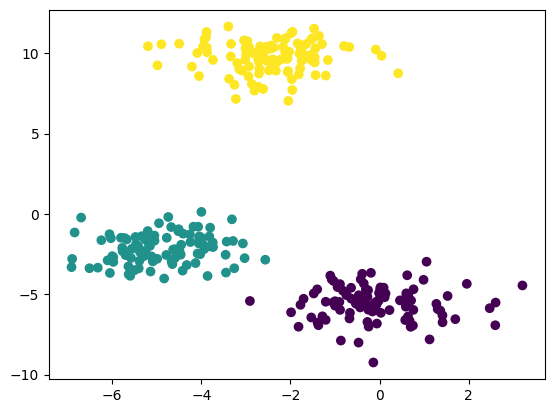

In [6]:
X,y = datasets.make_blobs(n_samples=n_samples,random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], c=y);

In [7]:
k=3

km=KMeans(k)
km.fit(X)
y_km=map_label(y,km.predict(X))

gmm=GMM(k, mu=km.centroids.copy())
gmm.fit(X)
y_gm=map_label(y, gmm.predict(X))

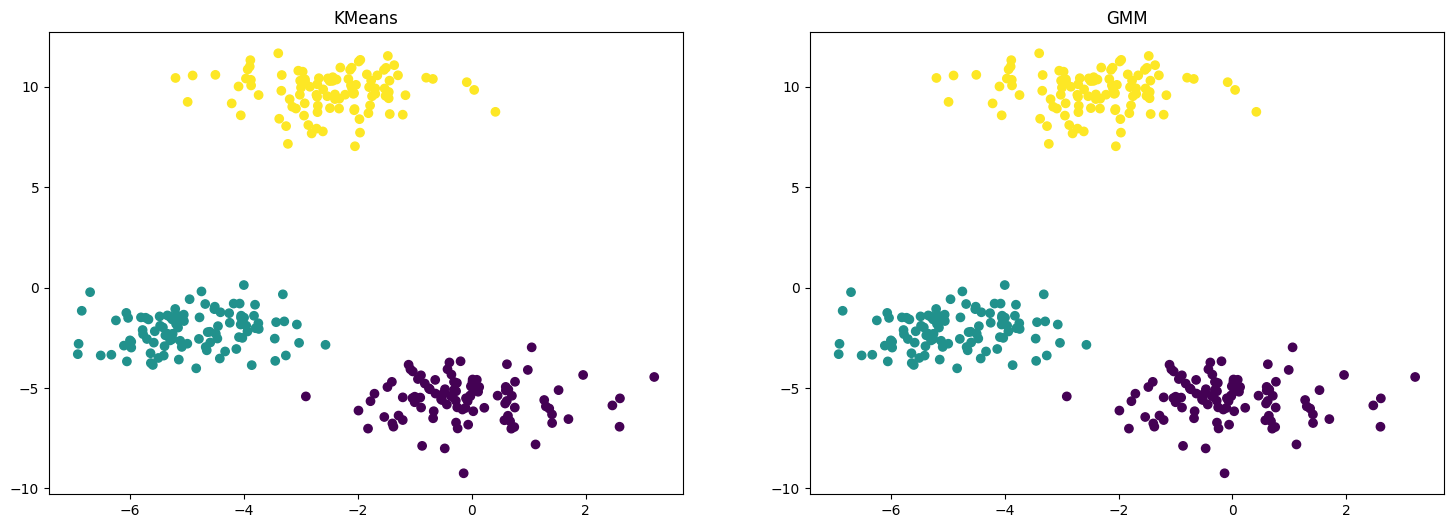

In [8]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y_km)
plt.title("KMeans")
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_gm)
plt.title("GMM");

In [9]:
 
data={
    'F1_Measure' : [f1_score(y, y_km, average='micro'), f1_score(y, y_gm, average='micro')],
    'NMI': [normalized_mutual_info_score(y, y_km), normalized_mutual_info_score(y, y_gm)],
    'Rand_Score': [rand_score(y, y_km), rand_score(y, y_gm)]
}
blobs_data = pd.DataFrame(data, index=['blobs_Kmean', 'blobs_GMM'])
blobs_data

,F1_Measure,NMI,Rand_Score
blobs_Kmean,1.0,1.0,1.0
blobs_GMM,1.0,1.0,1.0


## Dataset2

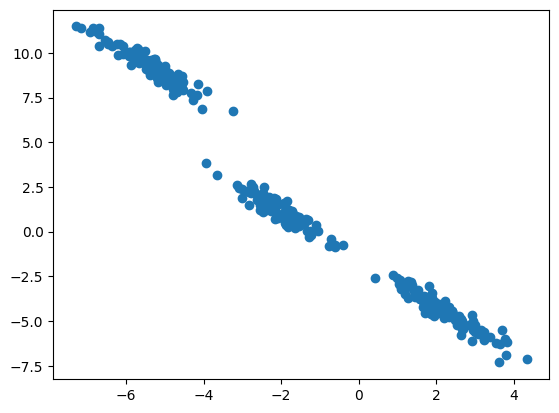

In [10]:
X, y = datasets.make_blobs(n_samples=n_samples,random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X = np.dot(X, transformation)
plt.scatter(X[:, 0], X[:, 1])

In [11]:
k=3

km=KMeans(k)
km.fit(X)
y_km=map_label(km.predict(X), y)

gmm=GMM(k, mu=km.centroids.copy())
gmm.fit(X)
y_gm=map_label(gmm.predict(X), y)

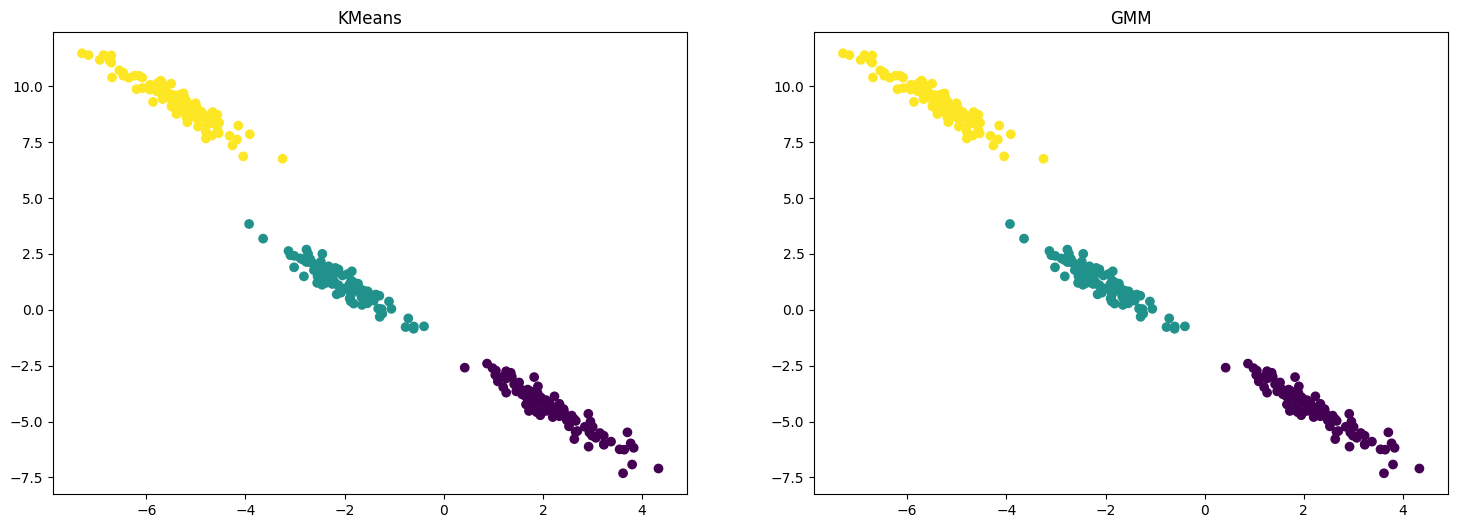

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y_km)
plt.title("KMeans")
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_gm)
plt.title("GMM");

In [13]:
 
data={
    'F1_Measure' : [f1_score(y, y_km, average='macro'), f1_score(y, y_gm, average='macro')],
    'NMI': [normalized_mutual_info_score(y, y_km), normalized_mutual_info_score(y, y_gm)],
    'Rand_Score': [rand_score(y, y_km), rand_score(y, y_gm)]
}
anisotropicly_data = pd.DataFrame(data, index=['anisotropicly_Kmean', 'anisotropicly_GMM'])
anisotropicly_data

,F1_Measure,NMI,Rand_Score
anisotropicly_Kmean,1.0,1.0,1.0
anisotropicly_GMM,1.0,1.0,1.0


## Dataset3

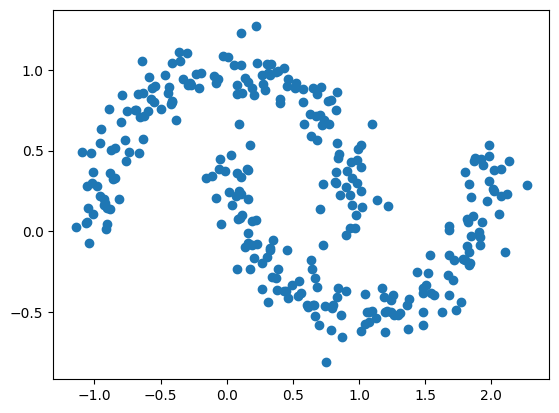

In [14]:
X, y = datasets.make_moons(n_samples=n_samples, noise=0.1,random_state=random_state)
plt.scatter(X[:, 0], X[:, 1])

In [15]:
k=3

km=KMeans(k)
km.fit(X)
y_km=map_label(y,km.predict(X))

gmm=GMM(k, mu=km.centroids.copy())
gmm.fit(X)
y_gm=map_label(y, gmm.predict(X))

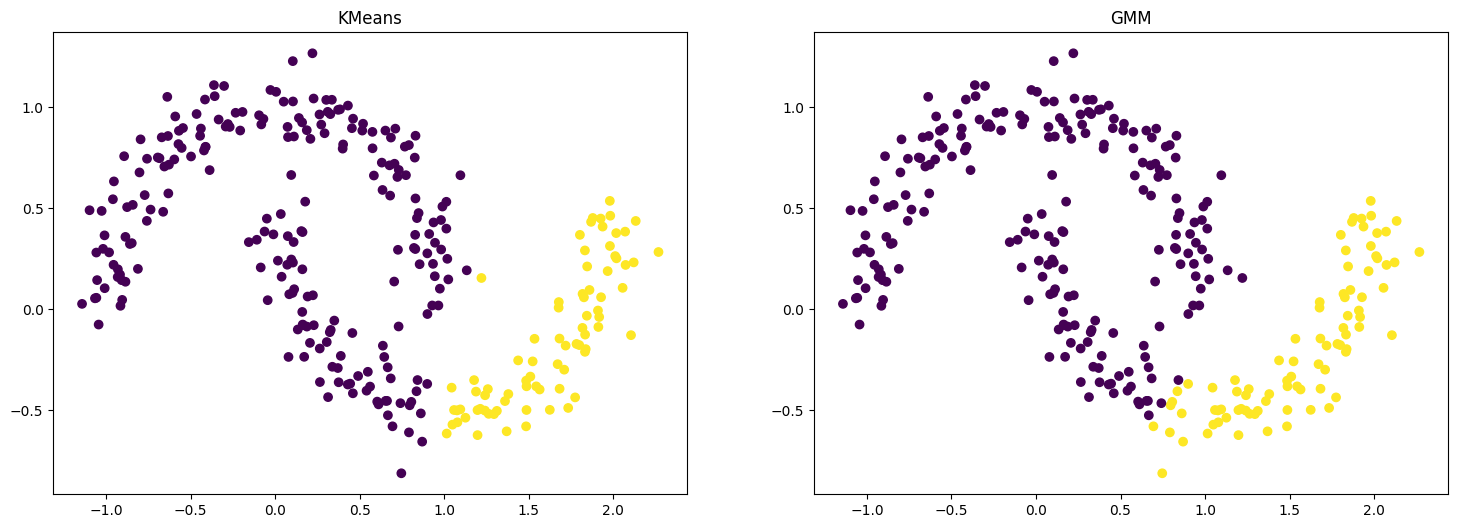

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y_km)
plt.title("KMeans")
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_gm)
plt.title("GMM");

In [17]:
data={
    'F1_Measure' : [f1_score(y, y_km, average='macro'), f1_score(y, y_gm, average='macro')],
    'NMI': [normalized_mutual_info_score(y, y_km), normalized_mutual_info_score(y, y_gm)],
    'Rand_Score': [rand_score(y, y_km), rand_score(y, y_gm)]
}
moon_data = pd.DataFrame(data, index=['moon_Kmean', 'moon_GMM'])
moon_data

,F1_Measure,NMI,Rand_Score
moon_Kmean,0.267025,0.326388,0.627113
moon_GMM,0.274725,0.399236,0.663233


## Dataset4

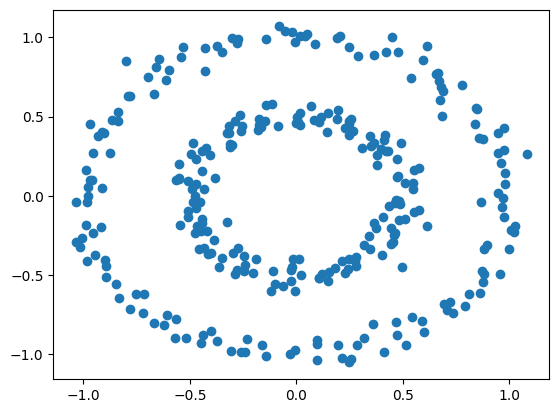

In [18]:
X,y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05,random_state=random_state)
plt.scatter(X[:, 0], X[:, 1])

In [19]:
k=3
km=KMeans(k)
km.fit(X)
y_km=map_label(y, km.predict(X))

gmm=GMM(k, mu=km.centroids.copy())
gmm.fit(X)
y_gm=map_label(y, gmm.predict(X))

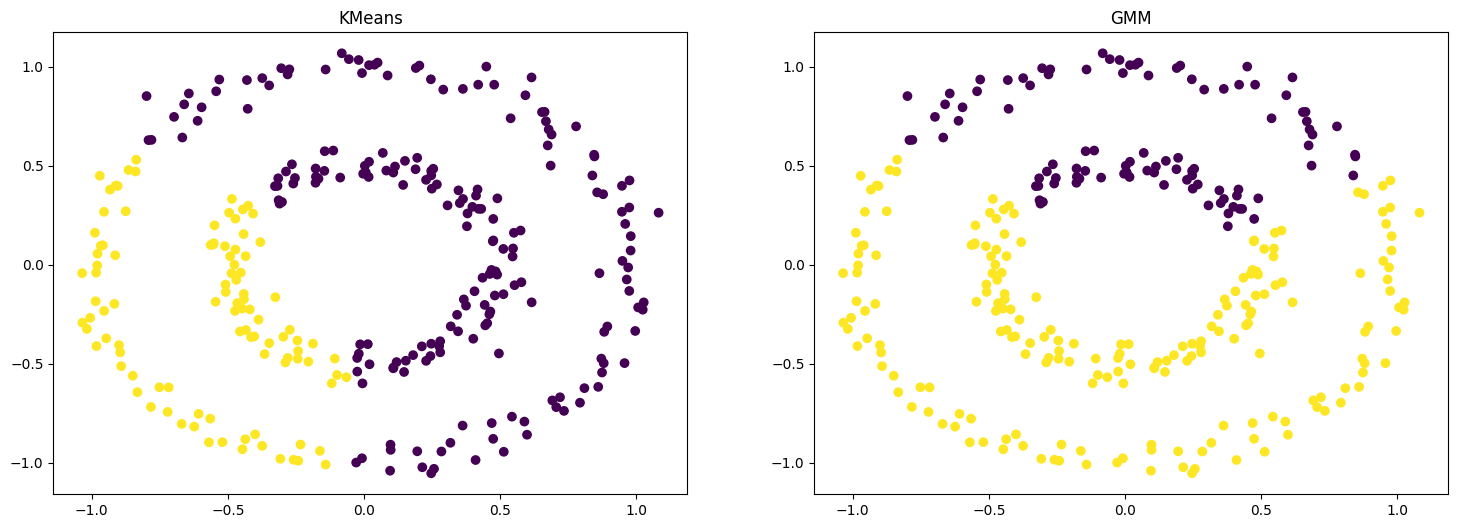

In [20]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y_km)
plt.title("KMeans")
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_gm)
plt.title("GMM");

In [21]:
data={
    'F1_Measure' : [f1_score(y, y_km, average='macro'), f1_score(y, y_gm, average='macro')],
    'NMI': [normalized_mutual_info_score(y, y_km), normalized_mutual_info_score(y, y_gm)],
    'Rand_Score': [rand_score(y, y_km), rand_score(y, y_gm)]
}

circles_data = pd.DataFrame(data, index=['circles_Kmean', 'circles_GMM'])
circles_data

,F1_Measure,NMI,Rand_Score
circles_Kmean,0.485714,0.000000,0.498328
circles_GMM,0.481687,0.000038,0.498350


## Summarization

In [26]:
results=pd.concat([blobs_data,anisotropicly_data,moon_data,circles_data])
print(results)

                     F1_Measure       NMI  Rand_Score
blobs_Kmean            1.000000  1.000000    1.000000
blobs_GMM              1.000000  1.000000    1.000000
anisotropicly_Kmean    1.000000  1.000000    1.000000
anisotropicly_GMM      1.000000  1.000000    1.000000
moon_Kmean             0.267025  0.326388    0.627113
moon_GMM               0.274725  0.399236    0.663233
circles_Kmean          0.485714  0.000000    0.498328
circles_GMM            0.481687  0.000038    0.498350


In [27]:
print(results[::2])

                     F1_Measure       NMI  Rand_Score
blobs_Kmean            1.000000  1.000000    1.000000
anisotropicly_Kmean    1.000000  1.000000    1.000000
moon_Kmean             0.267025  0.326388    0.627113
circles_Kmean          0.485714  0.000000    0.498328


In [28]:
print(results[1::2])

                   F1_Measure       NMI  Rand_Score
blobs_GMM            1.000000  1.000000    1.000000
anisotropicly_GMM    1.000000  1.000000    1.000000
moon_GMM             0.274725  0.399236    0.663233
circles_GMM          0.481687  0.000038    0.498350


In [29]:
print(results[1::2].sum(axis=0)/4)

F1_Measure    0.689103
NMI           0.599818
Rand_Score    0.790396
dtype: float64


In [30]:
print(results[::2].sum(axis=0)/4)

F1_Measure    0.688185
NMI           0.581597
Rand_Score    0.781360
dtype: float64


<Axes: >

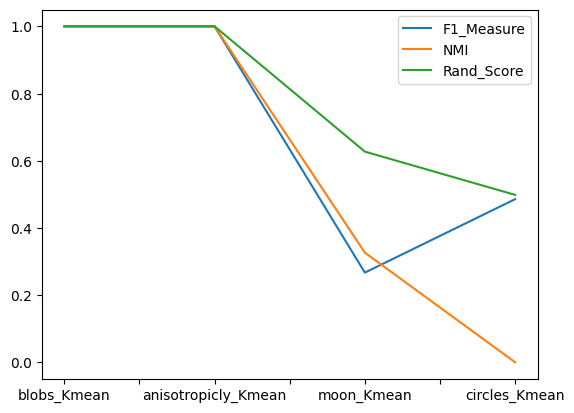

In [31]:
results[::2].plot()

<Axes: >

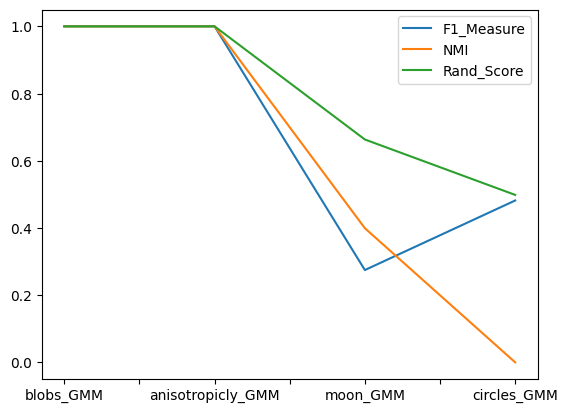

In [32]:
results[1::2].plot()

### This is not part of the project, but I made to test my understanding of the algorithm

In [33]:
class DBSCAN:
    def __init__(self, epsilon=1, min_pts=5):
        self.epsilon = epsilon
        self.min_pts = min_pts
        self.clusters = []
        self.noise = []

    @staticmethod
    def _euclidean_distance(point1, point2):
        return np.sqrt (np.sum ( (point1 - point2) ** 2))

    def _get_neighbors(self, dataset, point):
        neighbors = set()
        for index, candidate in enumerate (dataset):
            if self._euclidean_distance (point, candidate) < self.epsilon:
                neighbors.add(index)
        return neighbors

    def fit(self, dataset):
        visited = [False]*len(dataset)
        for index in range(len(dataset)):
            if not visited [index]:
                visited[index] = True
                neighbors = self._get_neighbors(dataset, dataset[index])
                if len (neighbors) < self.min_pts:
                    self.noise.append(index)
                else:
                    self._expand_cluster(dataset, visited, index, neighbors)
        return self.clusters, self.noise

    def _expand_cluster(self, dataset, visited, index, neighbors):
        self.clusters.append({index})

        while neighbors:
            next_index = neighbors.pop()
            if not visited [next_index]:
                visited [next_index] = True
                next_neighbors = self._get_neighbors (dataset, dataset[next_index])
                self.clusters[-1].add(next_index)
                if len (next_neighbors) >= self.min_pts:
                    neighbors.update(next_neighbors)
                



[]

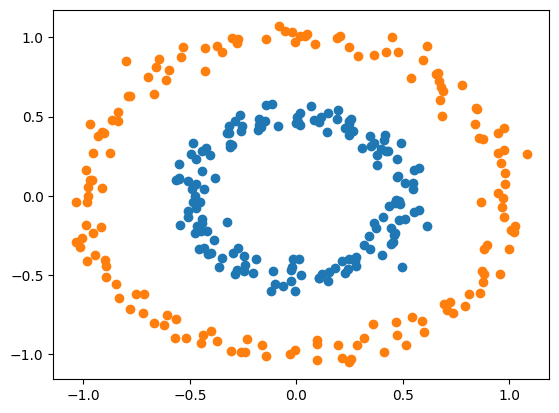

In [34]:
clusters, noise=DBSCAN(epsilon=0.2).fit(X)

for  cluster in clusters:
    indeices=list(cluster)
    plt.scatter(X[indeices,0],X[indeices,1])
len(clusters)
noise